# Gender Detection Using Keras - Inceptionv3

### Importing libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 
import seaborn as sns
from matplotlib import pyplot as plt

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

Using TensorFlow backend.


### Extracting Data

In [2]:
# set variables 
main_folder = '../input/celeba-dataset/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000506.jpg'


In [3]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

### Studying The Data

In [4]:
df_attr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202599 entries, 000001.jpg to 202599.jpg
Data columns (total 40 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   5_o_Clock_Shadow     202599 non-null  int64
 1   Arched_Eyebrows      202599 non-null  int64
 2   Attractive           202599 non-null  int64
 3   Bags_Under_Eyes      202599 non-null  int64
 4   Bald                 202599 non-null  int64
 5   Bangs                202599 non-null  int64
 6   Big_Lips             202599 non-null  int64
 7   Big_Nose             202599 non-null  int64
 8   Black_Hair           202599 non-null  int64
 9   Blond_Hair           202599 non-null  int64
 10  Blurry               202599 non-null  int64
 11  Brown_Hair           202599 non-null  int64
 12  Bushy_Eyebrows       202599 non-null  int64
 13  Chubby               202599 non-null  int64
 14  Double_Chin          202599 non-null  int64
 15  Eyeglasses           202599 non-null  int64

In [5]:
gender = df_attr["Male"]
# In gender array 0-Female while 1-Male
gender.head(5)

image_id
000001.jpg    0
000002.jpg    0
000003.jpg    1
000004.jpg    0
000005.jpg    0
Name: Male, dtype: int64

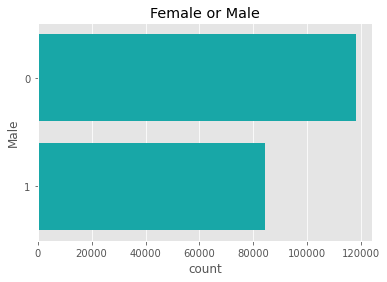

In [6]:
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

In [7]:
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


### Partitioning Data

In [8]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [9]:
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(gender, how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [10]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

In [11]:
TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000

x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

# Build the Model - Gender Recognition

In [12]:
IMG_HEIGHT = 218
IMG_WIDTH = 178
BATCH_SIZE = 100
NUM_EPOCHS = 5

inc_model = InceptionV3(weights= 'imagenet',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))

87916544/87910968 [==============================] - 3s 0us/step
number of layers: 311


#### Adding Custom layers

In [13]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [14]:
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [15]:
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

### Data Augmentation: Preprocessing

In [16]:
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

### Training Data

In [17]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/5
100/100 [==============================] - 1461s 15s/step - loss: 0.7058 - accuracy: 0.5411 - val_loss: 0.5633 - val_accuracy: 0.7420

Epoch 00001: val_loss improved from inf to 0.56334, saving model to weights.best.inc.male.hdf5
Epoch 2/5
100/100 [==============================] - 1446s 14s/step - loss: 0.6191 - accuracy: 0.6552 - val_loss: 0.4752 - val_accuracy: 0.8110

Epoch 00002: val_loss improved from 0.56334 to 0.47523, saving model to weights.best.inc.male.hdf5
Epoch 3/5
100/100 [==============================] - 1453s 15s/step - loss: 0.5474 - accuracy: 0.7392 - val_loss: 0.4375 - val_accuracy: 0.8055

Epoch 00003: val_loss improved from 0.47523 to 0.43750, saving model to weights.best.inc.male.hdf5
Epoch 4/5
100/100 [==============================] - 1436s 14s/step - loss: 0.4864 - accuracy: 0.7879 - val_loss: 0.3951 - val_accuracy: 0.8285

Epoch 00004: val_loss improved from 0.43750 to 0.39510, saving model to weights.best.inc.male.hdf5
Epoch 5/5
100/100 [=========

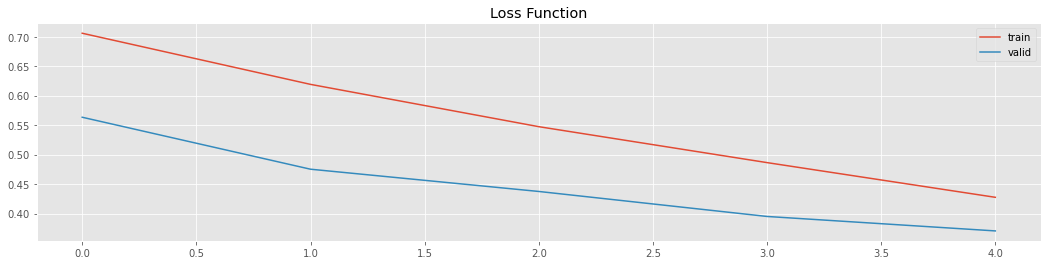

In [18]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

In [19]:
print (hist.history)

{'val_loss': [0.5633423909544945, 0.4752343863248825, 0.4374952919781208, 0.39509521052241325, 0.37058502472937105], 'val_accuracy': [0.7419999837875366, 0.8109999895095825, 0.8054999709129333, 0.828499972820282, 0.8349999785423279], 'loss': [0.7057957828044892, 0.619101396203041, 0.5473547944426537, 0.48641176640987394, 0.4275737702846527], 'accuracy': [0.5411, 0.6552, 0.7392, 0.7879, 0.822]}


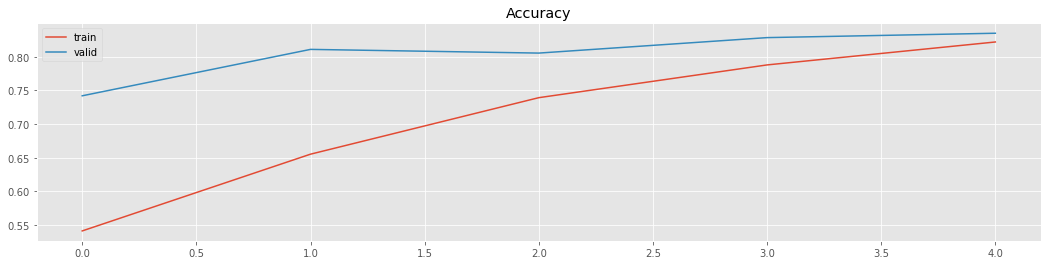

In [20]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [21]:
from sklearn.metrics import f1_score
TEST_SAMPLES = 2000
model_.load_weights('weights.best.inc.male.hdf5')

x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 85.2500%
f1_score: 0.8356545961002785


### We have an 83 percent accuracy by training the model for 25 minutes, the accuracy would only increase with the training time as the curve is still rising. 



Thanks to Marcos Alvarado, as took some help from his awesome work.